In [1]:
# import the necessary libraries
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset

# import dataloader class
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

# import visualisation tool
import matplotlib.pyplot as plt

# import time to time the training
import time


In [2]:
# load in our dataset
# define the dataset path
dataset_path = 'archive'
train_path = dataset_path + '/Training'
test_path = dataset_path + '/Testing'

In [20]:
# We will use EfficientNet 0b as our base pretrained model
from torchvision.models import efficientnet_b0

# Load the pretrained model
model_pretrained = efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

model_pretrained

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
# the model expects a 3 channel input image with size 224x224
# we will use the same transforms as the original model

# define the transforms
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# we transform our data using the transforms
# we will use the ImageFolder class to load the data

training_data = datasets.ImageFolder(train_path, transform=data_transforms)
testing_data = datasets.ImageFolder(test_path, transform=data_transforms)

# we want the data to be grouped into non-tumour and tumour. The non-tumour class is class 2, while the tumour classes are 0, 1 , 3

# we will create a custom dataset class to group the data into tumour and non-tumour classes
class_mapping = {0: 1, 1: 1, 2: 0, 3: 1}

class DatasetBinary(Dataset):
    def __init__(self, dataset, class_mapping):
        self.dataset = dataset
        self.class_mapping = class_mapping
        self.targets = [class_mapping[target] for _, target in self.dataset]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, target = self.dataset[idx]
        return data, self.class_mapping[target]

# create the binary datasets
training_data_binary = DatasetBinary(training_data, class_mapping)
testing_data_binary = DatasetBinary(testing_data, class_mapping)

# create the dataloaders
train_loader = DataLoader(training_data_binary, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data_binary, batch_size=32, shuffle=False)


In [21]:
# we should freeze the weights of the pretrained model
for param in model_pretrained.parameters():
    param.requires_grad = False

# unfreeze the last few layers
for param in model_pretrained.classifier.parameters():
    param.requires_grad = True

# we will add a new fully connected layer to the model
model_pretrained.fc = nn.Linear(1280, 2)

# define the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.parameters(), lr=0.001)

In [22]:
# print the model where gradient is required
for name, param in model_pretrained.named_parameters():
    if param.requires_grad:
        print(name)

classifier.1.weight
classifier.1.bias
fc.weight
fc.bias


In [16]:
if torch.cuda.is_available():
    print("Training on GPU, moving data to GPU...")
    device = torch.device('cuda')
    train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
    test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]

Epoch 1, Loss: 0.3061642050743103 performed in 3.8430535793304443 seconds
Epoch 2, Loss: 0.13272283971309662 performed in 3.755598545074463 seconds
Epoch 3, Loss: 0.16890422999858856 performed in 3.7650678157806396 seconds
Epoch 4, Loss: 0.12586498260498047 performed in 3.773658275604248 seconds
Epoch 5, Loss: 0.18186859786510468 performed in 3.7810065746307373 seconds
Epoch 6, Loss: 0.04666069522500038 performed in 3.7878127098083496 seconds
Epoch 7, Loss: 0.09111354500055313 performed in 3.7928168773651123 seconds
Epoch 8, Loss: 0.1264173835515976 performed in 3.799535036087036 seconds
Epoch 9, Loss: 0.13686195015907288 performed in 3.807603359222412 seconds
Epoch 10, Loss: 0.0971749946475029 performed in 3.8154754638671875 seconds
Training performed in 37.92239689826965 seconds


In [24]:
# train the model
if torch.cuda.is_available():
    model_pretrained.to(device)
    
epochs = 20
start = time.time()
train_start = start
train_loc = train_loader_gpu if torch.cuda.is_available() else train_loader
for epoch in range(epochs):
    model_pretrained.train()
    running_loss = 0.0
    for data, target in train_loc:
        optimizer.zero_grad()
        output = model_pretrained(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()} performed in {time.time() - start} seconds')
    start = time.time()
print(f'Training performed in {time.time() - train_start} seconds')

Epoch 1, Loss: 0.3312775790691376 performed in 3.7479615211486816 seconds
Epoch 2, Loss: 0.2427886426448822 performed in 3.727346181869507 seconds
Epoch 3, Loss: 0.11663568019866943 performed in 3.734405994415283 seconds
Epoch 4, Loss: 0.12702947854995728 performed in 3.745044231414795 seconds
Epoch 5, Loss: 0.28938037157058716 performed in 3.751821517944336 seconds
Epoch 6, Loss: 0.14654642343521118 performed in 3.756075859069824 seconds
Epoch 7, Loss: 0.13079513609409332 performed in 3.7611637115478516 seconds
Epoch 8, Loss: 0.08397623151540756 performed in 3.7689194679260254 seconds
Epoch 9, Loss: 0.1293671429157257 performed in 3.7761292457580566 seconds
Epoch 10, Loss: 0.2737312912940979 performed in 3.7838709354400635 seconds
Epoch 11, Loss: 0.14078480005264282 performed in 3.789332866668701 seconds
Epoch 12, Loss: 0.044435616582632065 performed in 3.7964439392089844 seconds
Epoch 13, Loss: 0.06977646052837372 performed in 3.8037726879119873 seconds
Epoch 14, Loss: 0.070739187300

In [ ]:
# device = torch.device('cuda')
# print(torch.cuda.memory_summary(device))

In [25]:
# evaluate the model
model_pretrained.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_pretrained(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy of the model on the test images: {100 * correct / total}%')


Accuracy of the model on the test images: 82.48730964467005%


<Axes: >

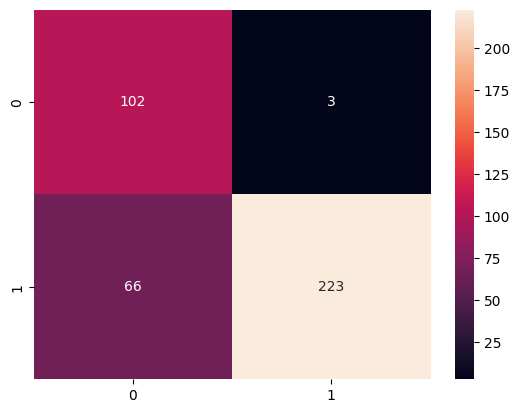

In [26]:
# we should plot the confusion matrix
import seaborn as sns
confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_pretrained(data)
        _, predicted = torch.max(output, 1)
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
sns.heatmap(confusion_matrix, annot=True, fmt='g')

Let's try unfreezing more of the pretrained model

In [67]:
# first let's unload the model from the GPU
model_pretrained.to('cpu')

# refresh the model by loading it again
model_pretrained = efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

# freeze the weights of the model
for param in model_pretrained.parameters():
    param.requires_grad = False

# add a new fully connected layer
model_pretrained.fc = nn.Linear(1280, 2)

# unfreeze the last few layers
for param in model_pretrained.classifier.parameters():
    param.requires_grad = True

for name, param in model_pretrained.features[8].named_parameters():
    param.requires_grad = True

for name, param in model_pretrained.features[7].named_parameters():
    param.requires_grad = True

# define the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.parameters(), lr=0.001)


In [68]:
# train the model
if torch.cuda.is_available():
    model_pretrained.to(device)

epochs = 10
start = time.time()
train_start = start
train_loc = train_loader_gpu if torch.cuda.is_available() else train_loader
for epoch in range(epochs):
    model_pretrained.train()
    running_loss = 0.0
    for data, target in train_loc:
        optimizer.zero_grad()
        output = model_pretrained(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()} performed in {time.time() - start} seconds')
    start = time.time()
print(f'Training performed in {time.time() - train_start} seconds')

Epoch 1, Loss: 0.16811197996139526 performed in 5.16062331199646 seconds
Epoch 2, Loss: 0.02281917817890644 performed in 5.136290550231934 seconds
Epoch 3, Loss: 0.002346714725717902 performed in 5.135092496871948 seconds
Epoch 4, Loss: 0.012403205968439579 performed in 5.133737087249756 seconds
Epoch 5, Loss: 0.016466522589325905 performed in 5.13481879234314 seconds
Epoch 6, Loss: 0.0007268197368830442 performed in 5.132519721984863 seconds
Epoch 7, Loss: 0.0012902140151709318 performed in 5.134418249130249 seconds
Epoch 8, Loss: 0.001395768253132701 performed in 5.133868932723999 seconds
Epoch 9, Loss: 0.004247272852808237 performed in 5.133009433746338 seconds
Epoch 10, Loss: 0.0011729482794180512 performed in 5.135013818740845 seconds
Training performed in 51.37011766433716 seconds


In [69]:
# evaluate the model
model_pretrained.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_pretrained(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy of the model on the test images: {100 * correct / total}%')

Accuracy of the model on the test images: 90.35532994923858%


Text(50.72222222222221, 0.5, 'Actual')

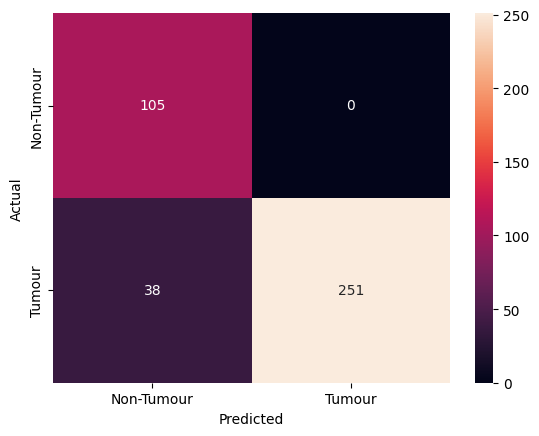

In [73]:
# we should plot the confusion matrix
confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_pretrained(data)
        _, predicted = torch.max(output, 1)
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
classes = ['Non-Tumour', 'Tumour']
sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
# set axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

This pretrained model is so good that we might venture to use it for the non-binary classification as well!

In [74]:
train_loader_quad = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader_quad = DataLoader(testing_data, batch_size=32, shuffle=False)

In [81]:
# place the old model in the cpu
model_pretrained.to('cpu')

# refresh the model
model_pretrained = efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

# freeze the weights of the model
for param in model_pretrained.parameters():
    param.requires_grad = False

# add a new fully connected layer
model_pretrained.fc = nn.Linear(1280, 4)

# unfreeze the last few layers
for param in model_pretrained.classifier.parameters():
    param.requires_grad = True

for name, param in model_pretrained.features[8].named_parameters():
    param.requires_grad = True

for name, param in model_pretrained.features[7].named_parameters():
    param.requires_grad = True

# define the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.parameters(), lr=0.001)

In [77]:
# put our data on the GPU
if torch.cuda.is_available():
    model_pretrained.to(device)
    train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader_quad]
    test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader_quad]

In [82]:
# put the model on the GPU if available
if torch.cuda.is_available():
    model_pretrained.to(device)

# train the model
epochs = 10
start = time.time()
train_start = start
train_loc = train_loader_gpu if torch.cuda.is_available() else train_loader_quad
for epoch in range(epochs):
    model_pretrained.train()
    running_loss = 0.0
    for data, target in train_loc:
        optimizer.zero_grad()
        output = model_pretrained(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()} performed in {time.time() - start} seconds')
    start = time.time()
print(f'Training performed in {time.time() - train_start} seconds')


Epoch 1, Loss: 0.449546217918396 performed in 4.459073543548584 seconds
Epoch 2, Loss: 0.16979752480983734 performed in 4.923378944396973 seconds
Epoch 3, Loss: 0.13476091623306274 performed in 5.132268667221069 seconds
Epoch 4, Loss: 0.012115035206079483 performed in 5.135428190231323 seconds
Epoch 5, Loss: 0.008595820516347885 performed in 5.131954669952393 seconds
Epoch 6, Loss: 0.0274189542979002 performed in 5.129905462265015 seconds
Epoch 7, Loss: 0.020234940573573112 performed in 5.129305124282837 seconds
Epoch 8, Loss: 0.009081510826945305 performed in 5.129240036010742 seconds
Epoch 9, Loss: 0.060229577124118805 performed in 5.129195213317871 seconds
Epoch 10, Loss: 0.062423225492239 performed in 5.131958246231079 seconds
Training performed in 50.43251276016235 seconds


In [83]:
# evaluate the model
model_pretrained.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_pretrained(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy of the model on the test images: {100 * correct / total}%')

Accuracy of the model on the test images: 78.1725888324873%


Text(50.58159722222221, 0.5, 'Actual')

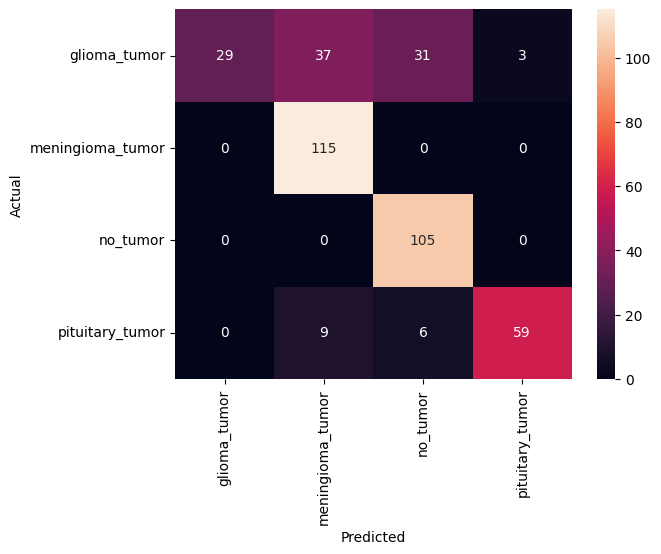

In [85]:
# we should plot the confusion matrix
confusion_matrix = torch.zeros(4, 4)
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_pretrained(data)
        _, predicted = torch.max(output, 1)
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
classes = train_loader_quad.dataset.classes
sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
# set axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')